## Dependencies

In [159]:
# This cell installs the required packages for the notebook.

%pip install requests pandas matplotlib scikit-learn seaborn gensim nltk spacy numpy


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports


In [160]:
# This cell imports all necessary libraries.

import requests
import pandas as pd
import numpy as np
import re
import time
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package punkt to /Users/idamora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset Generation

In [161]:
# This cell defines constants and book data for processing.

# Minimum rows of data per author
EXCERPTS_PER_AUTHOR = 600
# Target words per excerpt
TARGET_WORDS = 400
# Output filename
OUTPUT_FILE = "author_excerpts_victorian.csv"


BOOKS = {
    # More books for certain authors with shorter novels to ensure enough excerpts can be extracted
    "Anthony Trollope": [
        (619, "The Warden"),
        (18000, "Phineas Finn"),
        (7381, "The Eustace Diamonds"),
        (2860, "Framley Parsonage"),
        (5140, "He Knew He Was Right"),
        (23000, "Orley Farm"),
        (25001, "An Old Man's Love"),
        (4599, "The Small House at Allington"),
        (3166, "Doctor Thorne"),
        (18640, "Phineas Redux"),
        (15766, "The Claverings"),
    ],
    "Mary Elizabeth Braddon": [
        (8954, "Lady Audley's Secret"),
        (10905, "Phantom Fortune"),
        (48020, "Aurora Floyd, Vol. 1"),
        (9189, "Henry Dunbar"),
        (74385, "The Venetians"),
        (76927, "Only a clod"),
        (75125, "Eleanor's victory"),
        (9052, "The Golden Calf"),
        (54247, "Beyond These Voices"),
    ],
    "Charles Dickens": [
        (1400, "Great Expectations"),
        (766, "David Copperfield"),
        (98, "A Tale of Two Cities"),
        (730, "Oliver Twist"),
        (1023, "Bleak House"),
        (963, "Little Dorrit"),
        (786, "Hard Times"),
        (700, "The Old Curiosity Shop"),
    ],
    "Wilkie Collins": [
        (583, "The Woman in White"),
        (155, "The Moonstone"),
        (1622, "The Law and the Lady"),
        (1438, "No Name"),
        (1895, "Armadale"),
        (1917, "The Queen of Hearts"),
        (1628, "My Lady's Money"),
        (3633, "Jezebel's Daughter"),
        (1588, "A Rogue's Life"),
        (3632, "Poor Miss Finch"),
        (1624, "The Two Destinies"),
        (1623, "The New Magdalen"),
    ],
}

In [162]:
# This cell defines the function to download books from Project Gutenberg and extract excerpts for later use to create a dataset.

def download_book(book_id):
    """
    Downloads books from Project Gutenberg and creates a dataset of text excerpts.
    Args:
        book_id (int): The Project Gutenberg book ID.
    Returns:
        str: The text content of the book.
    """

    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            print(f"Downloaded ID: {book_id}")
            return response.text
    except Exception as e:
        print(f"Failed to download id:{book_id}: {e}")


def get_excerpts(text, num_excerpts):
    """
    Extracts a specified number of text excerpts from a given book text.
    Each excerpt contains a target number of words, and excerpts are spaced
    apart by a defined number of words to ensure diversity.
    Args:
        text (str): The full text of the book.
        num_excerpts (int): The number of excerpts to extract.
    Returns:
        list: A list of text excerpts.
    """

    # Number of words to skip between excerpts to ensure diversity
    SKIP_WORDS = 400

    start = text.find("*** START OF THE PROJECT GUTENBERG")
    if start != -1:
        text = text[start:]
    end = text.find("*** END OF THE PROJECT GUTENBERG")
    if end != -1:
        text = text[:end]

    # Remove preface up to Chapter 1
    chapter_match = re.search(r"chapter\s+(1|i)\b", text, re.IGNORECASE)
    if chapter_match:
        text = text[chapter_match.end() :]

    # Remove chapter headings
    text = re.sub(r"\bchapter\s+[ivxlcdm0-9]+\b\.?", "", text, flags=re.IGNORECASE)

    # Tokenize text into sentences and words
    sentences = sent_tokenize(text)
    words = text.split()

    excerpts = []
    index = 0

    # Extract excerpts spaced by SKIP_WORDS
    for _ in range(num_excerpts):
        if index + TARGET_WORDS > len(words):
            break
        char_index = len(" ".join(words[:index]))
        for i, sentence in enumerate(sentences):
            if text.find(sentence) >= char_index:
                remaining_text = " ".join(sentences[i:])
                excerpt_words = remaining_text.split()[:TARGET_WORDS]
                excerpts.append(" ".join(excerpt_words))
                break
        index += SKIP_WORDS

    return excerpts

In [163]:
# # This cell builds the dataset by downloading books and extracting excerpts.
# Runtime ~5 minutes

OUTPUT_FILE = "dataset.csv"


def build_dataset():
    """Builds the dataset by downloading books and extracting excerpts.
    Saves the dataset to a CSV file.
    """
    data = []
    for author, books in BOOKS.items():
        # Track running total per author
        author_total = 0
        excerpts_per_book = EXCERPTS_PER_AUTHOR // len(books)

        for i, (book_id, book_title) in enumerate(books):
            # Check if quota reached
            remaining = EXCERPTS_PER_AUTHOR - author_total
            if remaining <= 0:
                break

            if i == len(books) - 1:
                excerpts_needed = remaining
            else:
                excerpts_needed = min(excerpts_per_book, remaining)

            print(
                f"Processing {book_title} by {author}, requesting {excerpts_needed} excerpts."
            )

            text = download_book(book_id)
            if text is None:
                continue

            excerpts = get_excerpts(text, excerpts_needed)

            for excerpt in excerpts:
                data.append(
                    {
                        "book_id": book_id,
                        "author": author,
                        "book_title": book_title,
                        "excerpt": excerpt,
                    }
                )

            author_total += len(excerpts)
            time.sleep(0.5)

    df = pd.DataFrame(data)
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Dataset saved to {OUTPUT_FILE}")


# # This cell runs the dataset building process.
# # Do not run this cell again if the dataset is already built.
# # Cannot guarantee that *exactly* same excerpts will be extracted again.
# build_dataset()

In [164]:
# This cell loads the dataset and displays the count of excerpts per author.

df = pd.read_csv(OUTPUT_FILE)
print(df["author"].value_counts())

author
Anthony Trollope          600
Mary Elizabeth Braddon    600
Charles Dickens           600
Wilkie Collins            600
Name: count, dtype: int64


In [165]:
# This cell cleans the text excerpts by removing named entities, numbers, and chapter headings.
# Runtime ~ 2 mins

CLEANED_OUTPUT_FILE = "clean_dataset.csv"

en_spa = spacy.load("en_core_web_sm")


def clean_text(text):
    """
    Cleans the input text by removing named entities, numbers, and chapter headings.
    Args:
        text (str): The input text excerpt.
    Returns:
        str: The cleaned text excerpt.
    """
    doc = en_spa(text)
    tokens = []

    for token in doc:
        # Remove named entities
        if token.ent_type_ in [
            "PERSON",
            "GPE",
            "LOC",
            "CARDINAL",
            "ORDINAL",
            "TIME",
            "DATE",
        ]:
            continue
        # Remove any stray numbers
        if token.like_num:
            continue
        # Remove punctuation
        if token.is_punct:
            continue
        # Remove stray tokens with digits or underscores
        if any(ch.isdigit() for ch in token.text):
            continue
        if "_" in token.text:
            continue
        tokens.append(token.text.lower())

    cleaned_text = " ".join(tokens)
    cleaned_tokens = re.sub(r"\s+", " ", cleaned_text).strip()
    return cleaned_tokens


# File clean_dataset.csv already exists. No need to run this cell again.
# df["clean_excerpt"] = df["excerpt"].apply(clean_text)
# df.drop(columns=["excerpt"], inplace=True)
# df.to_csv(CLEANED_OUTPUT_FILE, index=False)
# print(f"Cleaned dataset saved to {CLEANED_OUTPUT_FILE}")

In [166]:
df = pd.read_csv(CLEANED_OUTPUT_FILE)
print(df["author"].value_counts())
df.head()

author
Anthony Trollope          600
Mary Elizabeth Braddon    600
Charles Dickens           600
Wilkie Collins            600
Name: count, dtype: int64


,book_id,author,book_title,clean_excerpt
0,619,Anthony Trollope,The Warden,hiram 's hospital the rev. was since a benefic...
1,619,Anthony Trollope,The Warden,be this as it may some years since had married...
2,619,Anthony Trollope,The Warden,such was the condition of hiram 's old men whe...
3,619,Anthony Trollope,The Warden,in this manner the income of the warden had in...
4,619,Anthony Trollope,The Warden,hiram 's hospital as the retreat is called is ...


## Vectorisation Methods

In [167]:
# This cell creates a bag-of-words representation of the cleaned text excerpts.

# Create bag-of-words representation
vectoriser = CountVectorizer(max_df=0.7)
count = vectoriser.fit_transform(df["clean_excerpt"])

print(count.shape)
print(vectoriser.get_feature_names_out()[:10])

(2400, 23349)
['abandon' 'abandoned' 'abandoning' 'abandonment' 'abandons' 'abashed'
 'abasing' 'abate' 'abatement' 'abbey']


In [168]:
# This cell creates a TF-IDF representation of the cleaned text excerpts.

# Create TF-IDF representation
tf_idf_vectoriser = TfidfVectorizer(sublinear_tf=True, max_df=0.7)
tf_idf = tf_idf_vectoriser.fit_transform(df["clean_excerpt"])

print(tf_idf.shape)
print(tf_idf_vectoriser.get_feature_names_out()[:10])

(2400, 23349)
['abandon' 'abandoned' 'abandoning' 'abandonment' 'abandons' 'abashed'
 'abasing' 'abate' 'abatement' 'abbey']


In [169]:
# This cell creates a bigram representation of the cleaned text excerpts.

# Bigram settings as in documentation
N_GRAM_RANGE = (2, 2)

# Create bigram representation
bi_gram_vectoriser = CountVectorizer(ngram_range=N_GRAM_RANGE, max_df=0.7)
bigram = bi_gram_vectoriser.fit_transform(df["clean_excerpt"])

print(bigram.shape)
print(bi_gram_vectoriser.get_feature_names_out()[:10])

(2400, 292086)
['abandon all' 'abandon her' 'abandon it' 'abandon myself' 'abandon that'
 'abandon the' 'abandon themselves' 'abandon those' 'abandoned all'
 'abandoned and']


In [170]:
# This cell trains a Word2Vec CBOW model on the cleaned text excerpts.
# Runtime ~ 4s

# Word2Vec CBOW model training

tokenised_texts = [text.split() for text in df["clean_excerpt"]]

cbow_model = Word2Vec(
    sentences=tokenised_texts,
    vector_size=100,
    window=5,
    min_count=10,
    epochs=15,
    sg=0,
    seed=SEED,
    # Set for reproducibility
    workers=1
)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [171]:
# This cell trains a Word2Vec Skip-gram model on the cleaned text excerpts.
# Runtime ~13s

skipgram_model = Word2Vec(
    sentences=tokenised_texts,
    vector_size=100,
    window=5,
    min_count=10,
    epochs=15,
    sg=1,
    seed=SEED,
    workers=1
)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [172]:
# This cell creates document vectors by averaging word vectors from the trained Word2Vec models.


def get_document_vector(tokens, model, vector_size):
    """
    Generates a document vector by averaging the word vectors of the tokens.
    Args:
        tokens (list): List of tokens in the document.
        model (Word2Vec): Trained Word2Vec model.
        vector_size (int): Size of the word vectors.
    Returns:
        np.ndarray: The averaged document vector.
    """
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)


# Create document vectors for CBOW model
cbow_vectors = np.array(
    [get_document_vector(tokens, cbow_model, 100) for tokens in tokenised_texts]
)
# Create document vectors for Skip-gram model
skipgram_vectors = np.array(
    [get_document_vector(tokens, skipgram_model, 100) for tokens in tokenised_texts]
)

## Evaluator

In [173]:
# Table 1
# This cell evaluates word similarities using the trained Word2Vec models.

similar_pairs = [
    ("said", "replied"),
    ("son", "daughter"),
    ("brother", "sister"),
]

for w1, w2 in similar_pairs:
    if w1 in cbow_model.wv and w2 in cbow_model.wv:
        similarity = cbow_model.wv.similarity(w1, w2)
        print(f"CBOW Similarity between '{w1}' and '{w2}': {similarity:.4f}")
    if w1 in skipgram_model.wv and w2 in skipgram_model.wv:
        similarity = skipgram_model.wv.similarity(w1, w2)
        print(f"Skip-gram Similarity between '{w1}' and '{w2}': {similarity:.4f}")
        print("\n")

CBOW Similarity between 'said' and 'replied': 0.8311
Skip-gram Similarity between 'said' and 'replied': 0.7669


CBOW Similarity between 'son' and 'daughter': 0.7225
Skip-gram Similarity between 'son' and 'daughter': 0.4944


CBOW Similarity between 'brother' and 'sister': 0.7704
Skip-gram Similarity between 'brother' and 'sister': 0.5793




In [174]:
# Table 1
# This cell evaluates dissimilar word pairs using the trained Word2Vec models.

dissimilar_pairs = [
    ("man", "table"),
    ("said", "blue"),
    ("home", "tree"),
]

for w1, w2 in dissimilar_pairs:
    if w1 in cbow_model.wv and w2 in cbow_model.wv:
        similarity = cbow_model.wv.similarity(w1, w2)
        print(f"CBOW Similarity between '{w1}' and '{w2}': {similarity:.4f}")
    if w1 in skipgram_model.wv and w2 in skipgram_model.wv:
        similarity = skipgram_model.wv.similarity(w1, w2)
        print(f"Skip-gram Similarity between '{w1}' and '{w2}': {similarity:.4f}")
        print("\n")

CBOW Similarity between 'man' and 'table': -0.0275
Skip-gram Similarity between 'man' and 'table': 0.1537


CBOW Similarity between 'said' and 'blue': -0.0916
Skip-gram Similarity between 'said' and 'blue': 0.1849


CBOW Similarity between 'home' and 'tree': 0.0570
Skip-gram Similarity between 'home' and 'tree': 0.2164




In [ ]:
# Table 2
# This cell evaluates word analogies using the trained Word2Vec models.

analogies = [
    # Expecting "brother"
    ("mother", "father", "sister"),
    # Expecting "talked"
    ("walk", "walked", "talk"),
    # Expecting "gentleman"
    ("woman", "man", "lady"),
]

for a, a_star, b in analogies:
    if a in cbow_model.wv and a_star in cbow_model.wv and b in cbow_model.wv:
        result = cbow_model.wv.most_similar(positive=[a_star, b], negative=[a], topn=1)
        print(
            f"CBOW Analogy: '{a}' is to '{a_star}' as '{b}' is to '{result[0][0]}' (score: {result[0][1]:.4f})"
        )
    if (
        a in skipgram_model.wv
        and a_star in skipgram_model.wv
        and b in skipgram_model.wv
    ):
        result = skipgram_model.wv.most_similar(
            positive=[a_star, b], negative=[a], topn=1
        )
        print(
            f"Skip-gram Analogy: '{a}' is to '{a_star}' as '{b}' is to '{result[0][0]}' (score: {result[0][1]:.4f})"
        )
        print("\n")

CBOW Analogy: 'mother' is to 'father' as 'sister' is to 'brother' (score: 0.7525)
Skip-gram Analogy: 'mother' is to 'father' as 'sister' is to 'brother' (score: 0.5464)


CBOW Analogy: 'walk' is to 'walked' as 'talk' is to 'talked' (score: 0.6500)
Skip-gram Analogy: 'walk' is to 'walked' as 'talk' is to 'listened' (score: 0.4670)


CBOW Analogy: 'woman' is to 'man' as 'lady' is to 'gentleman' (score: 0.6614)
Skip-gram Analogy: 'woman' is to 'man' as 'lady' is to 'gentleman' (score: 0.6088)




In [176]:
# This cell stores all vectorisation methods used in the notebook for use in later analysis.

vectorisations = {
    "Bag-of-Words": count,
    "TF-IDF": tf_idf,
    "Bigrams": bigram,
    "Word2Vec CBOW": cbow_vectors,
    "Word2Vec Skip-gram": skipgram_vectors,
}

# Store colours for each author for visualisation purposes.

colours = {
    "Anthony Trollope": "crimson",
    "Mary Elizabeth Braddon": "royalblue",
    "Charles Dickens": "mediumseagreen",
    "Wilkie Collins": "plum",
}

## Clustering

In [177]:
# This cell performs KMeans clustering on each vectorisation and displays the distribution of authors in each cluster.
# Runtime ~10s

cluster_results = {}

for name, X in vectorisations.items():
    print(f"{name}\n")

    if hasattr(X, "toarray"):
        X_array = X.toarray()
    else:
        X_array = X

    kmeans = KMeans(n_clusters=4, random_state=SEED)
    clusters = kmeans.fit_predict(X_array)
    cluster_results[name] = clusters

    for cluster_id in range(4):
        print(f"  Cluster {cluster_id}:")
        for author in df["author"].unique():
            count_in_cluster = np.sum(
                (clusters == cluster_id) & (df["author"] == author)
            )
            print(f"\t\t\t{author}: {count_in_cluster}")
    print()

Bag-of-Words

  Cluster 0:
			Anthony Trollope: 136
			Mary Elizabeth Braddon: 103
			Charles Dickens: 128
			Wilkie Collins: 120
  Cluster 1:
			Anthony Trollope: 6
			Mary Elizabeth Braddon: 38
			Charles Dickens: 120
			Wilkie Collins: 267
  Cluster 2:
			Anthony Trollope: 324
			Mary Elizabeth Braddon: 319
			Charles Dickens: 298
			Wilkie Collins: 128
  Cluster 3:
			Anthony Trollope: 134
			Mary Elizabeth Braddon: 140
			Charles Dickens: 54
			Wilkie Collins: 85

TF-IDF

  Cluster 0:
			Anthony Trollope: 2
			Mary Elizabeth Braddon: 123
			Charles Dickens: 168
			Wilkie Collins: 415
  Cluster 1:
			Anthony Trollope: 325
			Mary Elizabeth Braddon: 24
			Charles Dickens: 10
			Wilkie Collins: 51
  Cluster 2:
			Anthony Trollope: 40
			Mary Elizabeth Braddon: 389
			Charles Dickens: 248
			Wilkie Collins: 101
  Cluster 3:
			Anthony Trollope: 233
			Mary Elizabeth Braddon: 64
			Charles Dickens: 174
			Wilkie Collins: 33

Bigrams

  Cluster 0:
			Anthony Trollope: 3
			Mary Elizabet

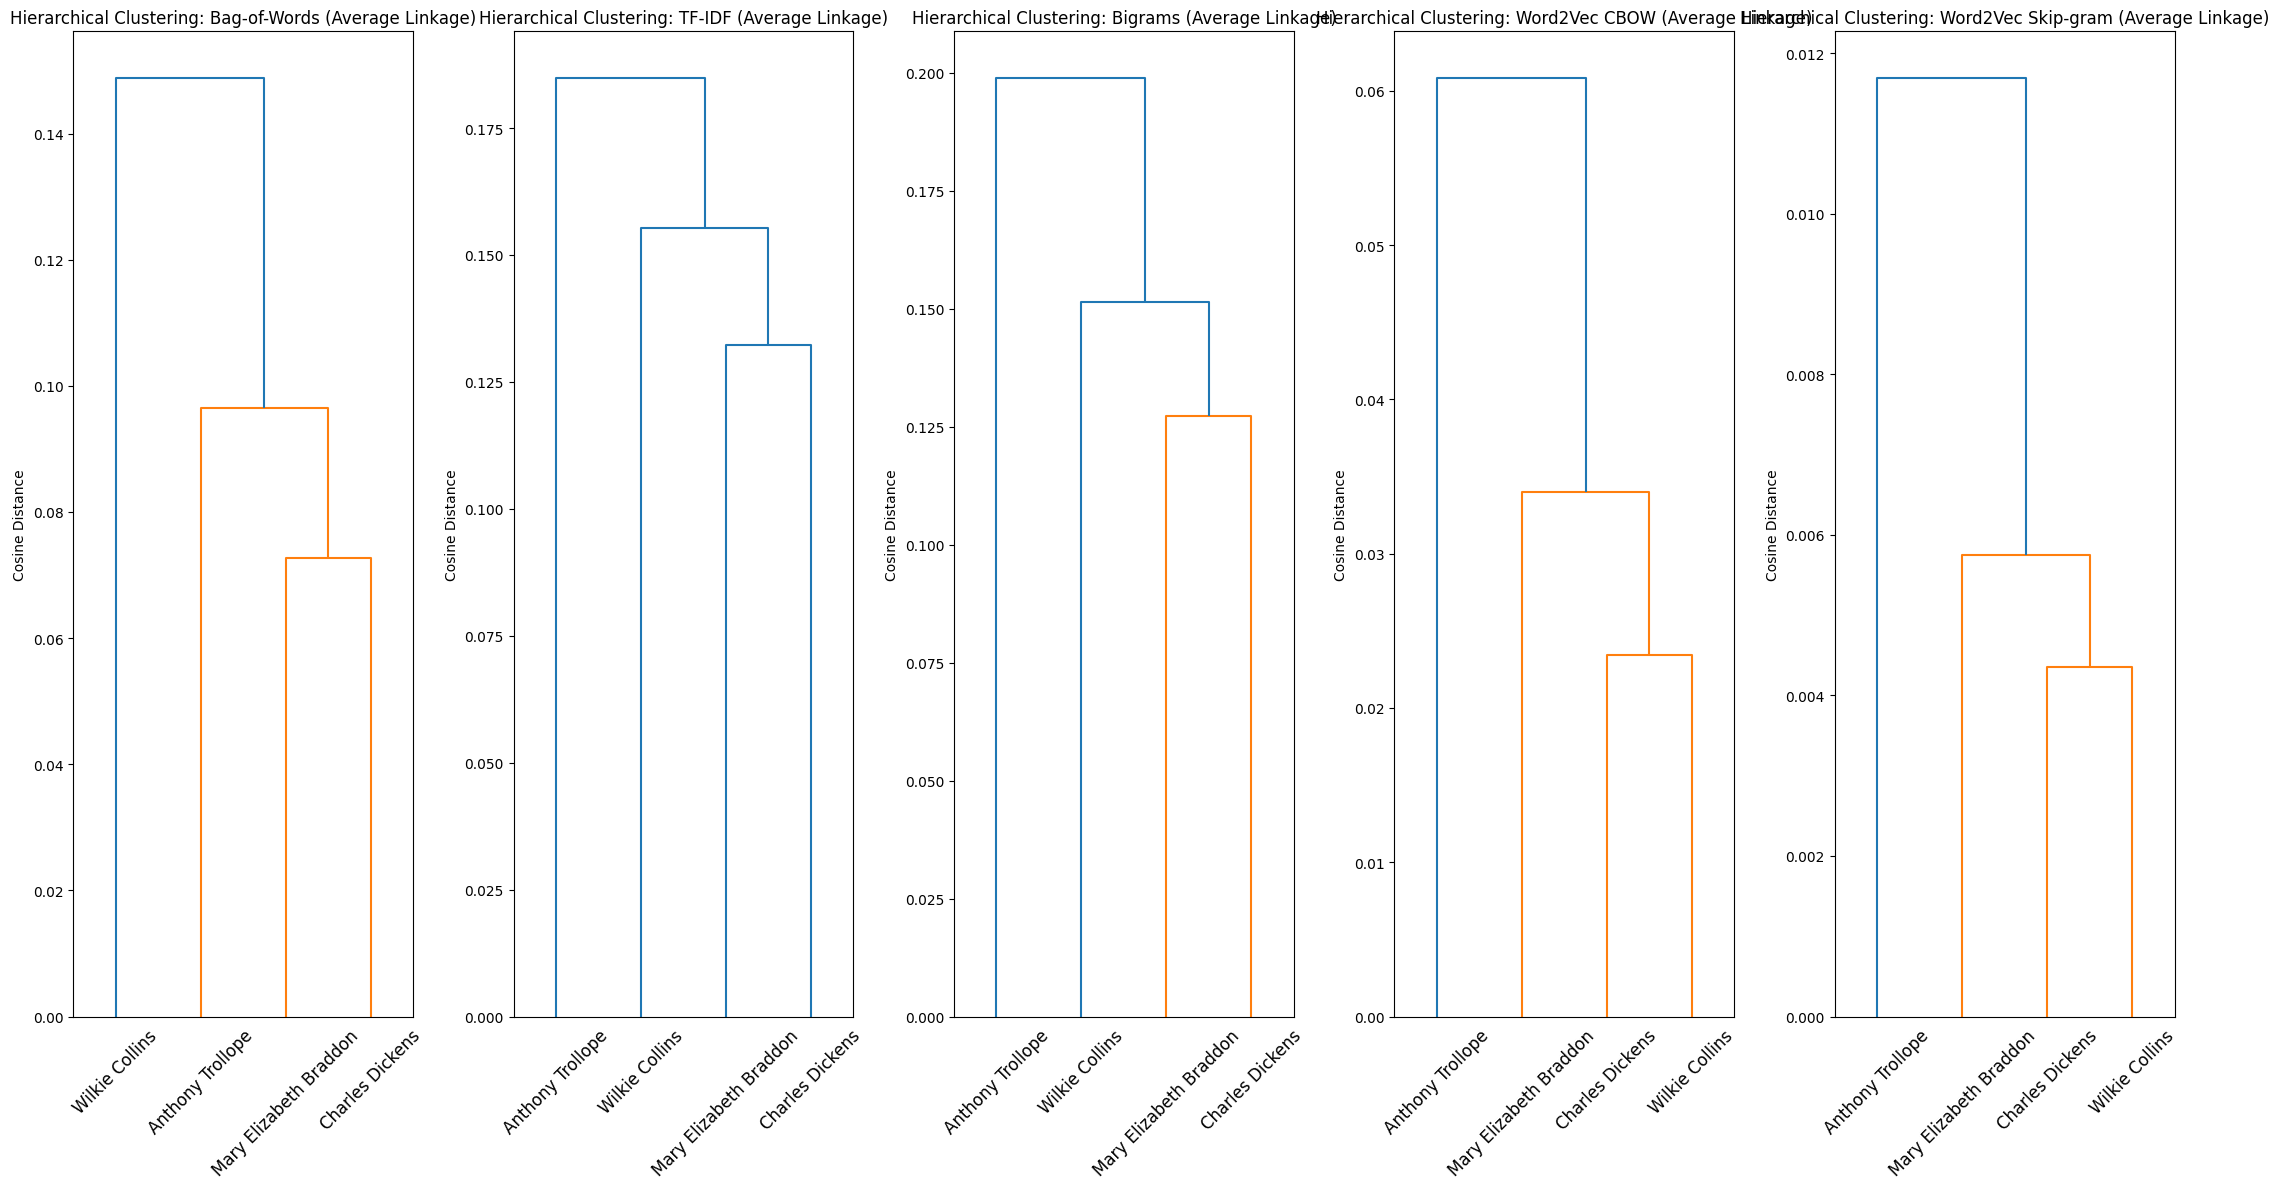

In [178]:
# This cell creates hierarchical clustering dendrograms for all vectorisation methods.

authors = df["author"].unique()

fig, axes = plt.subplots(1, 5, figsize=(22, 12))
for i, (name, X) in enumerate(vectorisations.items()):

    if hasattr(X, "toarray"):
        X_dense = X.toarray()
    else:
        X_dense = X

    author_vectors = np.array(
        [X_dense[df["author"] == author].mean(axis=0) for author in authors]
    )

    Z = linkage(author_vectors, method="average", metric="cosine")
    dendrogram(Z, labels=authors, ax=axes[i], leaf_rotation=45)
    axes[i].set_title(f"Hierarchical Clustering: {name} (Average Linkage)")
    axes[i].set_ylabel("Cosine Distance")

plt.tight_layout()
plt.show()

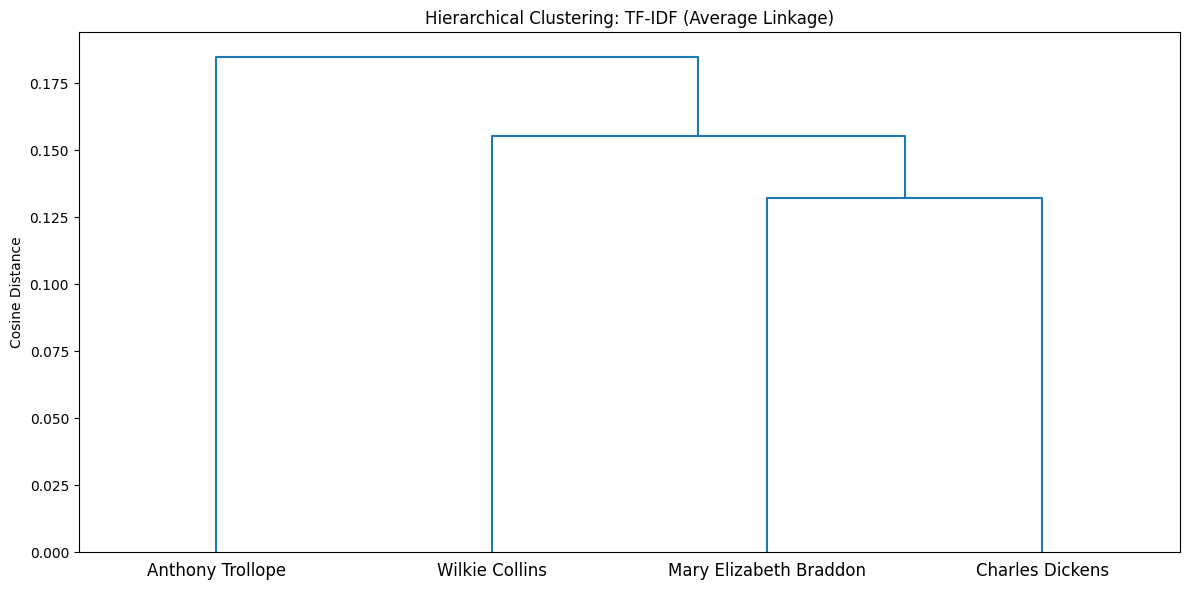

In [ ]:
# Figure 1
# This cell creates a hierarchical clustering dendrogram specifically for the TF-IDF vectorisation method.

authors = df["author"].unique()

X = vectorisations["TF-IDF"]
X_dense = X.toarray() if hasattr(X, "toarray") else X

author_vectors = np.array(
    [X_dense[df["author"] == author].mean(axis=0) for author in authors]
)

Z = linkage(author_vectors, method="average", metric="cosine")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
dendrogram(Z, labels=authors, ax=ax)
ax.set_title("Hierarchical Clustering: TF-IDF (Average Linkage)")
ax.set_ylabel("Cosine Distance")

plt.tight_layout()
plt.show()

## Visualisation

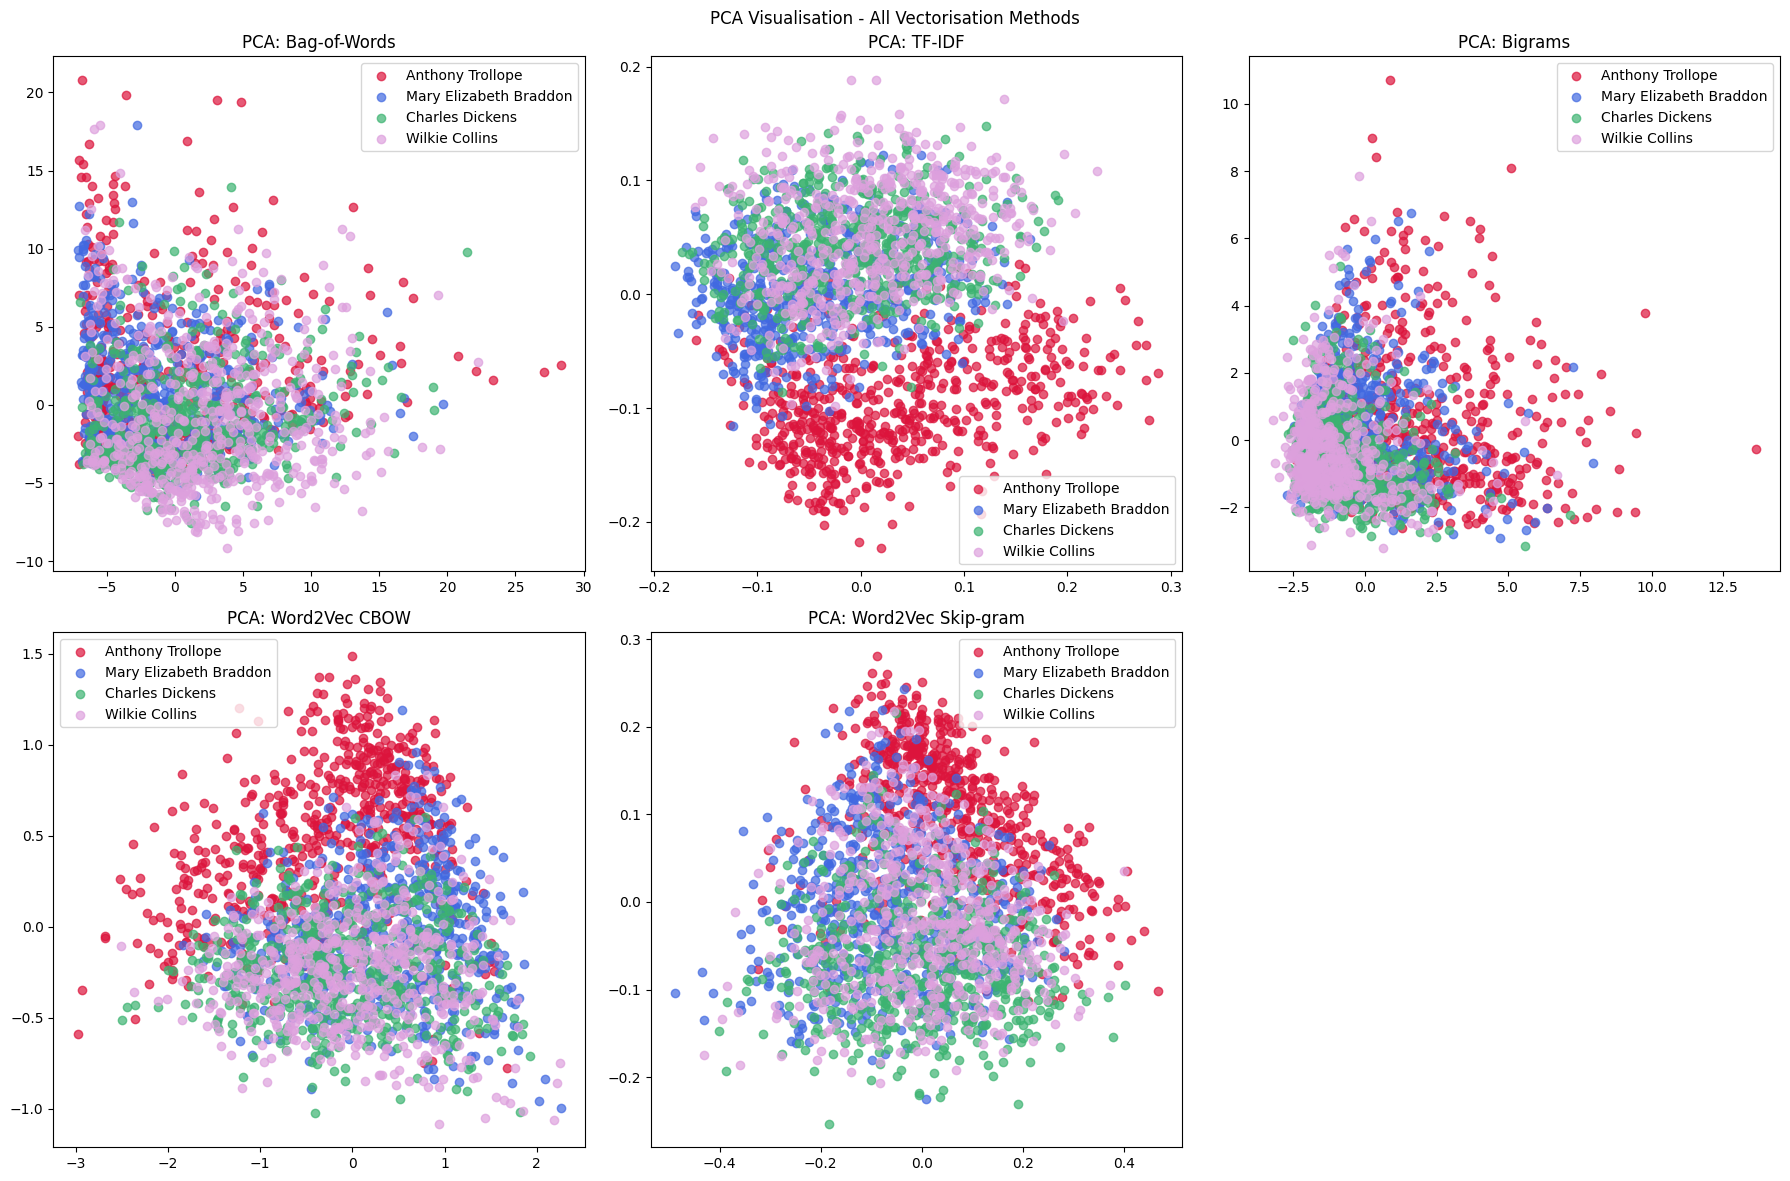

In [ ]:
# Figure 2
# This cell creates PCA visualisations for all vectorisation methods.
# Runtime ~6s

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, X) in enumerate(vectorisations.items()):
    if hasattr(X, "toarray"):
        X_dense = X.toarray()
    else:
        X_dense = X

    pca = PCA(n_components=2, random_state=SEED)
    X_2d = pca.fit_transform(X_dense)

    # Plot each author
    for author in df["author"].unique():
        mask = df["author"] == author
        axes[idx].scatter(
            X_2d[mask, 0], X_2d[mask, 1], alpha=0.7, label=author, color=colours[author]
        )
    axes[idx].set_title(f"PCA: {name}")
    axes[idx].legend()

axes[5].axis("off")

plt.suptitle("PCA Visualisation - All Vectorisation Methods")
plt.tight_layout()
plt.show()

In [181]:
# This cell shows the top 10 words per cluster after K-Means clustering on TF-IDF.

df_clusters = pd.DataFrame(tf_idf.todense()).groupby(cluster_results['TF-IDF']).mean()
terms = tf_idf_vectoriser.get_feature_names_out()

print("Top 10 Words Per Cluster:\n")
for i, r in df_clusters.iterrows():
    top_words = [terms[t] for t in np.argsort(r)[-10:]]
    print(f"Cluster {i}: {', '.join(top_words)}")

Top 10 Words Per Cluster:

Cluster 0: do, when, what, we, your, is, she, you, me, my
Cluster 1: there, were, man, such, who, mr, should, himself, would, she
Cluster 2: their, little, who, there, or, an, they, upon, were, she
Cluster 3: your, know, what, she, mr, my, me, is, do, you


In [182]:
# This cell shows the top 10 words per cluster after K-Means clustering on TF-IDF filtering by sublinear TF scaling and max_df=0.7.

filtered_tf_idf_vectoriser = TfidfVectorizer(sublinear_tf=True, max_df=0.7)
tf_idf = filtered_tf_idf_vectoriser.fit_transform(df["clean_excerpt"])

df_clusters = pd.DataFrame(tf_idf.todense()).groupby(cluster_results["TF-IDF"]).mean()
terms = filtered_tf_idf_vectoriser.get_feature_names_out()

print("Top 10 Words Per Cluster:\n")
for i, r in df_clusters.iterrows():
    top_words = [terms[t] for t in np.argsort(r)[-10:]]
    print(f"Cluster {i}: {', '.join(top_words)}")

Top 10 Words Per Cluster:

Cluster 0: do, when, what, we, your, is, she, you, me, my
Cluster 1: there, were, man, such, who, mr, should, himself, would, she
Cluster 2: their, little, who, there, or, an, they, upon, were, she
Cluster 3: your, know, what, she, mr, my, me, is, do, you


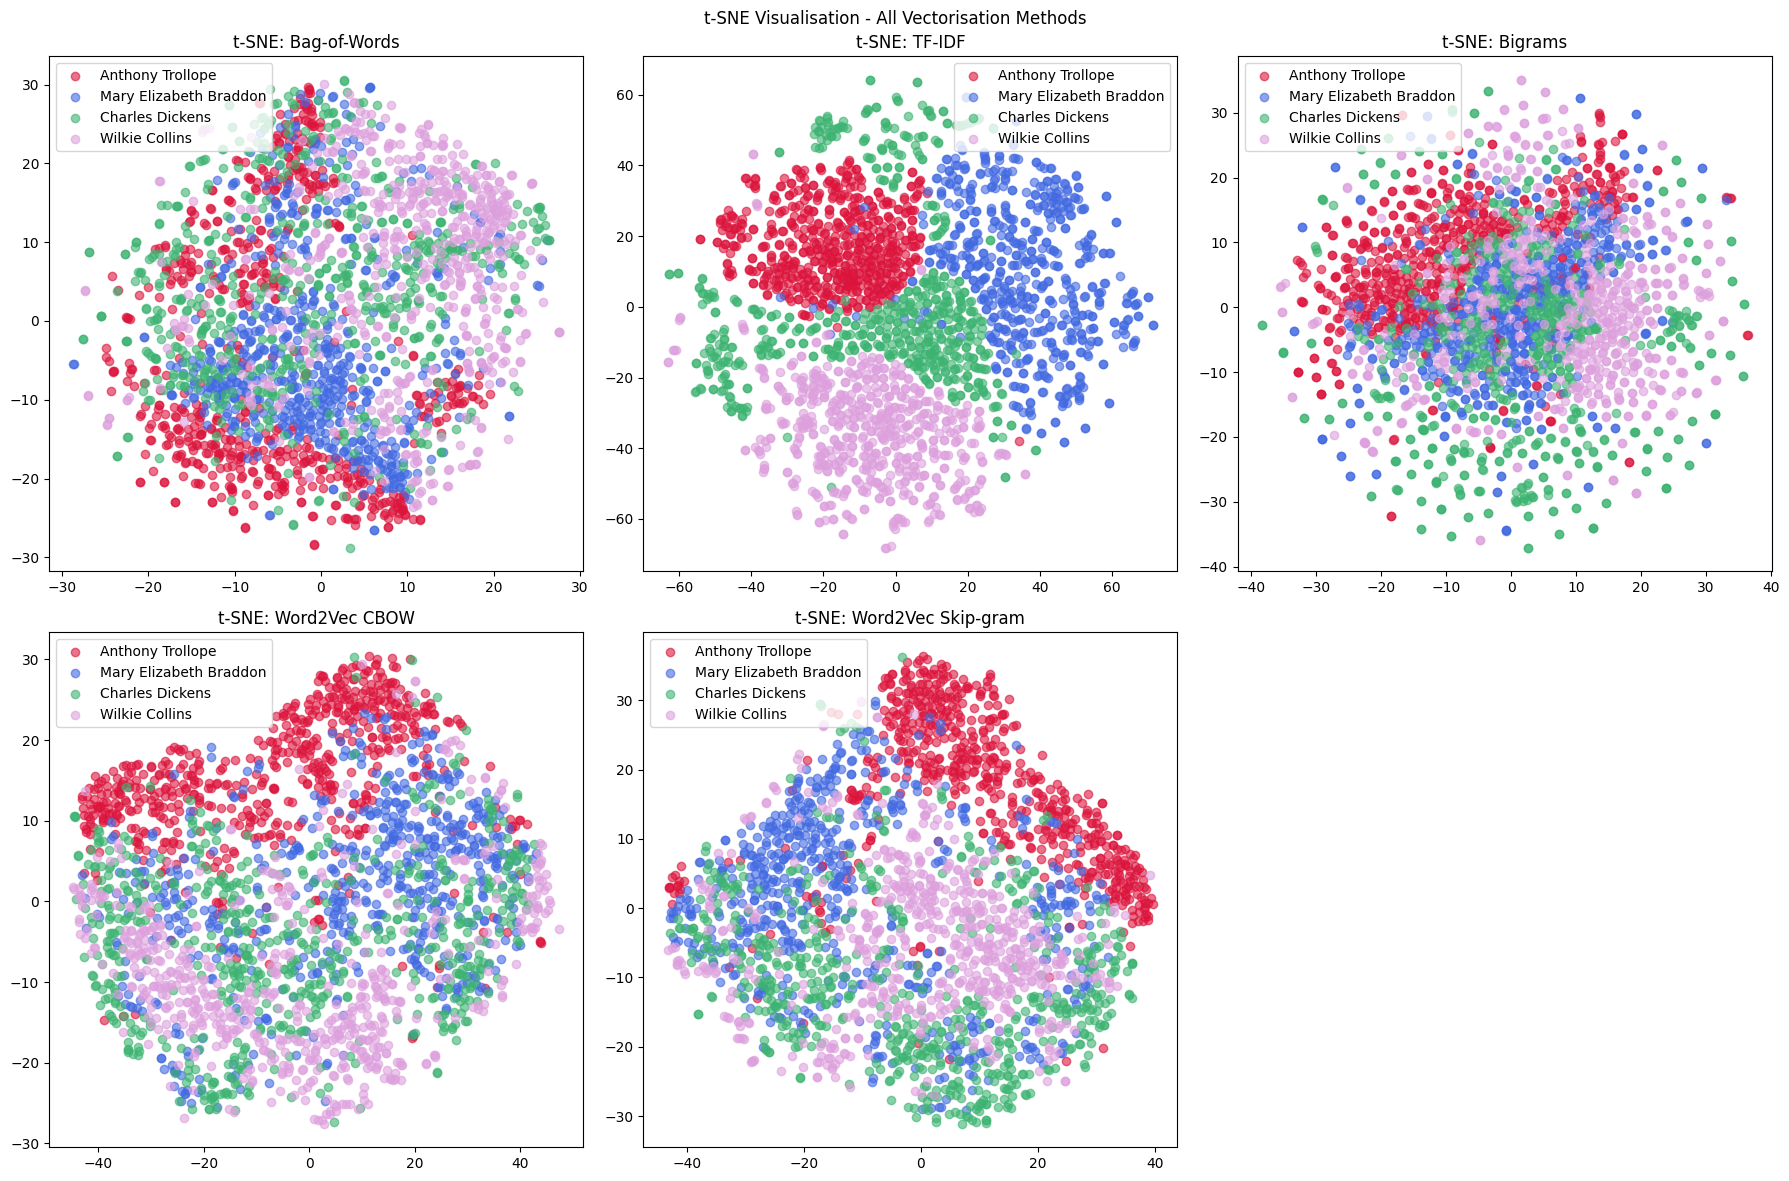

In [ ]:
# Figure 3
# This cell creates t-SNE visualisations for all vectorisation methods.
# Runtime ~45s

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, X) in enumerate(vectorisations.items()):

    if hasattr(X, "toarray"):
        X_dense = X.toarray()
    else:
        X_dense = X

    tsne = TSNE(n_components=2, perplexity=50, random_state=SEED)
    X_2d = tsne.fit_transform(X_dense)

    for author in df["author"].unique():
        mask = df["author"] == author
        axes[idx].scatter(
            X_2d[mask, 0], X_2d[mask, 1], alpha=0.6, label=author, color=colours[author]
        )
    axes[idx].set_title(f"t-SNE: {name}")
    axes[idx].legend()

axes[5].axis("off")

plt.suptitle("t-SNE Visualisation - All Vectorisation Methods")
plt.tight_layout()
plt.show()

In [184]:
# This cell evaluates each vectorisation method using the silhouette score from KMeans clustering.
# Runtime ~15s

from sklearn.metrics import silhouette_score

for name, X in vectorisations.items():
    X_dense = X.toarray() if hasattr(X, "toarray") else X
    clusters = KMeans(n_clusters=4, random_state=SEED).fit_predict(X_dense)
    score = silhouette_score(X_dense, clusters)
    print(f"{name}: {score:.4f}")

Bag-of-Words: 0.0437
TF-IDF: 0.0005
Bigrams: 0.0050
Word2Vec CBOW: 0.1583
Word2Vec Skip-gram: 0.1219


In [ ]:
# Table 3
# This cell evaluates each vectorisation method using a Logistic Regression classifier.
# Runtime ~3s

labels = df["author"].values
results = {}

print("Vectorisation method accuracy:")

for name, X in vectorisations.items():
    # Train-test split with stratification to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, random_state=SEED, stratify=labels
    )

    # Train Logistic Regression classifier
    clf = LogisticRegression(
        random_state=SEED,
        max_iter=1000,
    )
    clf.fit(X_train, y_train)

    # Predict and evaluate accuracy
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

Vectorisation method accuracy:
Bag-of-Words: 0.9583
TF-IDF: 0.9771
Bigrams: 0.9458
Word2Vec CBOW: 0.8646
Word2Vec Skip-gram: 0.8271


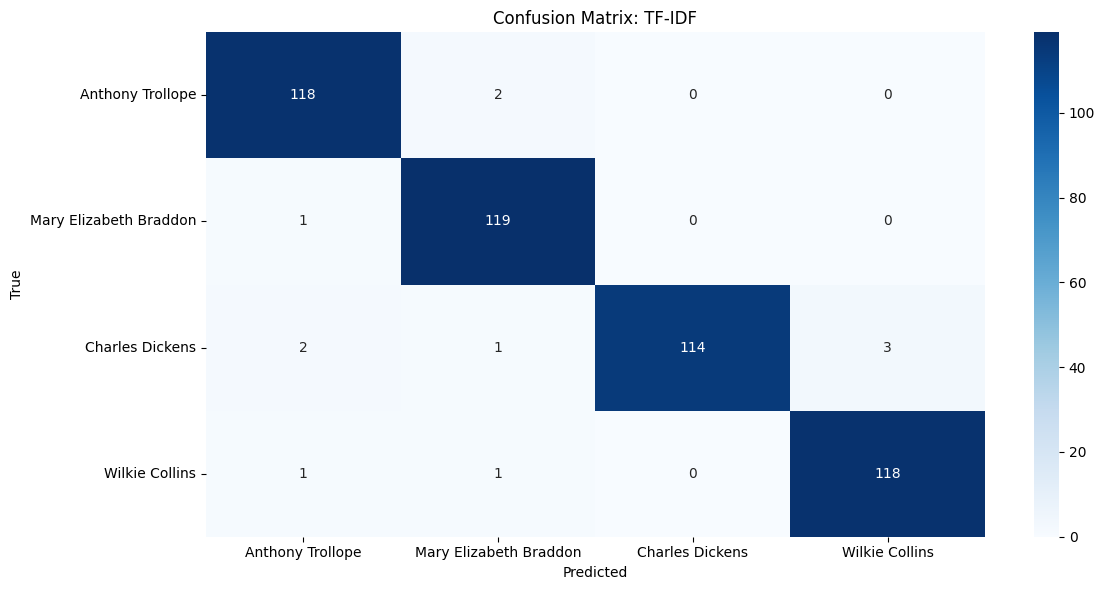

In [ ]:
# Figure 4
# This cell generates and displays confusion matrices for the best performing vectorisation method.

name = "TF-IDF"  # Set based on previous results
vectoriser = TfidfVectorizer(sublinear_tf=True, max_df=0.7)
X = vectoriser.fit_transform(df["clean_excerpt"])

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Train Logistic Regression classifier
clf = LogisticRegression(
    random_state=SEED,
    max_iter=1000,
)
clf.fit(X_train, y_train)
# Predict and evaluate accuracy
y_pred = clf.predict(X_test)

plt.figure(figsize=(12, 6))
cm = confusion_matrix(y_test, y_pred, labels=df["author"].unique())
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=df["author"].unique(),
    yticklabels=df["author"].unique(),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix: {name}")
plt.tight_layout()
plt.show()

In [187]:
# This cell identifies and displays the top 10 distinctive words per author using the best TF-IDF vectorisation.

vectoriser = TfidfVectorizer(sublinear_tf=True, max_df=0.7)
X = vectoriser.fit_transform(df["clean_excerpt"])

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=SEED, stratify=labels
)

clf = LogisticRegression(random_state=SEED, max_iter=1200)
clf.fit(X_train, y_train)

feature_names = vectoriser.get_feature_names_out()

print("Top 10 Distinctive Words Per Author:\n")
for i, author in enumerate(clf.classes_):
    top_indices = clf.coef_[i].argsort()[-10:][::-1]
    top_words = [feature_names[j] for j in top_indices]
    print(f"{author}: {', '.join(top_words)}")

Top 10 Distinctive Words Per Author:

Anthony Trollope: should, would, then, such, though, also, did, himself, much, phineas
Charles Dickens: returned, being, boy, replied, peggotty, fire, child, em, quilp, upon
Mary Elizabeth Braddon: upon, vera, girl, papa, daughter, miss, scarcely, young, dr, poor
Wilkie Collins: my, me, myself, next, our, woman, own, words, us, magdalen


## Investigation on TF-IDF parameters

In [188]:
# This cell evaluates the effect of sublinear TF scaling in TF-IDF vectorisation on classification accuracy.

labels = df["author"].values

for sublin in [True, False]:
    vectoriser = TfidfVectorizer(sublinear_tf=sublin, max_df=0.7)
    X = vectoriser.fit_transform(df["clean_excerpt"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, random_state=SEED, stratify=labels
    )

    clf = LogisticRegression(random_state=SEED, max_iter=1200)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))

    print(f"sublinear_tf={sublin}: {acc:.4f} (features: {X.shape[1]})")

sublinear_tf=True: 0.9771 (features: 23349)
sublinear_tf=False: 0.9750 (features: 23349)


In [189]:
# This cell evaluates the effect of varying max_df in TF-IDF vectorisation on classification accuracy.

labels = df["author"].values

for max_df in [0.5, 0.6, 0.7, 0.8, 0.9]:
    vectoriser = TfidfVectorizer(sublinear_tf=True, max_df=max_df)
    X = vectoriser.fit_transform(df["clean_excerpt"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, random_state=SEED, stratify=labels
    )

    clf = LogisticRegression(random_state=SEED, max_iter=1200)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))

    print(f"max_df={max_df}: {acc:.4f} (features: {X.shape[1]})")

max_df=0.5: 0.9771 (features: 23325)
max_df=0.6: 0.9771 (features: 23338)
max_df=0.7: 0.9771 (features: 23349)
max_df=0.8: 0.9771 (features: 23359)
max_df=0.9: 0.9729 (features: 23367)
